In [5]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from keras.optimizers import Adam
from tqdm import tqdm

In [6]:
def create_model(state_size, action_size, learning_rate=0.003, layer_size=24):
    model = Sequential()
    model.add(Dense(layer_size, input_dim=state_size, activation='relu'))
    model.add(Dense(layer_size, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    
    model.compile(loss='mse', optimizer=Adam(learning_rate))
    return model

In [7]:
class Agent():
    
    def __init__(self, state_size, action_size):
        
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model()
        self.memory = deque(maxlen=2000)
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.gamma = 0.95
        
    def build_model(self, layer_size=24, learning_rate=0.003):
        model = Sequential()
        model.add(Dense(layer_size, input_dim=self.state_size, activation='relu'))
        model.add(Dense(layer_size, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(learning_rate))
        
        return model
        
    def action(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        actions = self.model.predict(state)[0]
        return np.argmax(actions)
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
                return
        sample_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = self.model.predict(state)
            if not done:
                target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            else:
                target[0][action] = reward
            self.model.fit(state, target, epochs=1, verbose=0)

        self.exploration_rate = max(self.exploration_min, self.exploration_rate * self.exploration_decay)
    
    def learn(self, env, nb_episodes, max_step_by_episode=200, batch_size=32):
        scores = []
        pbar = tqdm(range(nb_episodes))
        for i in pbar:
            state = np.reshape(env.reset(), [1, self.state_size])
            nb_steps_this_episode = 0
            done = False
            while not done:
                action = self.action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.remember(state, action, reward, next_state, done)
                nb_steps_this_episode += 1
                if done:
                    break
                state = next_state
            pbar.set_description("episode: %s, nb_steps_this_episode: %s" % (i, nb_steps_this_episode))
            scores.append(nb_steps_this_episode)
            self.replay(batch_size)
        return scores
     

episode: 0, nb_steps_this_episode: 39:   0%|          | 0/500 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


episode: 499, nb_steps_this_episode: 10: 100%|██████████| 500/500 [04:19<00:00,  1.92it/s]


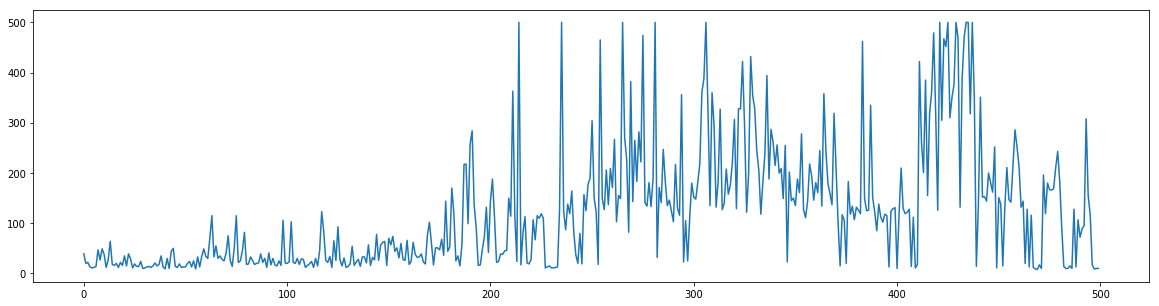

In [8]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)
scores = agent.learn(env, 500)
plt.figure(figsize=(20,5))
plt.plot(scores)

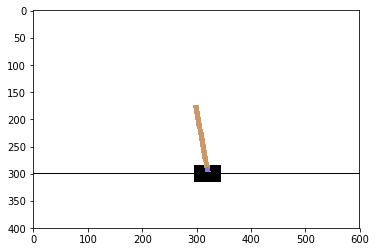

In [9]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import gym
%matplotlib inline

s = env.reset()
done = False
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
while not done:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = agent.action(np.reshape(s, [1, state_size]))
    s, _, done, _ = env.step(action)
    if done:
        break

In [10]:
agent.model.save_weights("./weights/dqn_cartpole.h5")